In [83]:
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import Voltus_Project_Nathan_Functions as functions

In [44]:
pd.options.display.max_rows = 100

# Initial Data Processing and EDA

In [2]:
# connecting to the server
conn = psycopg2.connect(
    database="interval_load_data",
    user='postgres',
    password='Onei9yepahShac0renga',
    host="test-interval-load-data.cwr8xr5dhgm1.us-west-2.rds.amazonaws.com",
    port="5432"
)

In [306]:
# querying the sites and their time period
site_df = pd.read_sql_query("SELECT site_id, \
                             MIN(interval_end) as time_start, \
                             MAX(interval_end) as time_end, \
                             (MAX(interval_end) - MIN(interval_end)) as series_length, \
                             COUNT(*) as interval_counts, \
                             AVG(interval_width) as mean_interval_width \
                             FROM intervals \
                             GROUP BY site_id;", conn)

In [309]:
# checking for nulls, only found for kWh
null_df = pd.read_sql_query('SELECT COUNT(*) as kWh_nulls \
                             FROM intervals \
                             WHERE "kWh" IS NULL;', conn)
null_df

,kwh_nulls
0,23


In [4]:
# vast majority of data has intervals of 15-minutes or 1-hour
# the 4 other will need to be looked at in more depth
site_df['mean_interval_width'].value_counts()

900.000000     270
3600.000000     93
996.322396       3
949.035874       1
Name: mean_interval_width, dtype: int64

In [5]:
# general inspection
site_df

,site_id,time_start,time_end,series_length,interval_counts,mean_interval_width
0,35f1db19-ab26-7f30-3451-971f053712f6,2015-05-15 05:00:00,2018-10-04 04:00:00,1237 days 23:00:00,118845,900.0
1,a05598bc-59ac-6697-0673-0e87e7ccc677,2018-06-01 05:15:00,2018-10-07 05:00:00,127 days 23:45:00,12288,900.0
2,b8ec0850-c5ce-1579-5438-8d1247f0ff16,2016-09-05 05:00:00,2018-09-07 04:00:00,731 days 23:00:00,17568,3600.0
3,b9ad1c9b-fbe2-f36f-ab2a-6894c251433f,2018-08-17 07:15:00,2018-09-01 07:00:00,14 days 23:45:00,1056,900.0
4,61ff3699-aad4-35d3-4ecb-b8195e8b08cd,2015-01-01 05:00:00,2018-10-22 04:00:00,1389 days 23:00:00,133434,900.0
...,...,...,...,...,...,...
362,debc4593-d7e7-c1ae-f268-f6944c531e3f,2015-05-15 05:00:00,2018-10-12 04:00:00,1245 days 23:00:00,119452,900.0
363,8a2629e5-183b-05c3-7544-5ac89ee3c347,2018-05-04 05:00:00,2018-10-12 04:00:00,160 days 23:00:00,15453,900.0
364,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2017-06-21 04:15:00,2018-10-12 04:00:00,477 days 23:45:00,45888,900.0
365,a85566bd-7cea-eb51-6aa5-912ee6bdd7d7,2015-05-15 05:00:00,2018-10-12 04:00:00,1245 days 23:00:00,119505,900.0


In [6]:
# checking for nulls and confirming datatypes
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   site_id              367 non-null    object         
 1   time_start           367 non-null    datetime64[ns] 
 2   time_end             367 non-null    datetime64[ns] 
 3   series_length        367 non-null    timedelta64[ns]
 4   interval_counts      367 non-null    int64          
 5   mean_interval_width  367 non-null    float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 17.3+ KB


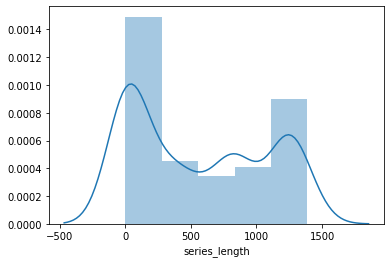

In [7]:
# inspecting the distribution in time series length in days
sns.distplot(site_df['series_length'].dt.days)

In [8]:
# checking for any really small time series and it looks like one might not have enough data to evaluate
# some only have a day of data, but at least you can check that day for start/stop, DR and gaps
site_df['series_length'].sort_values().head()

78    00:00:00
317   23:00:00
213   23:00:00
25    23:00:00
140   23:00:00
Name: series_length, dtype: timedelta64[ns]

In [21]:
# This site only has a single data point, so it will be excluded from further analysis
site_check = pd.read_sql_query("SELECT * \
                               FROM intervals \
                               WHERE site_id='44236c0b-b566-0af2-6675-6854fa9378dd';", conn)
site_check

,kWh,interval_end,interval_width,site_id
0,98.142,2018-08-20 05:15:00,900,44236c0b-b566-0af2-6675-6854fa9378dd


In [308]:
site_df.drop(78, inplace=True)
site_df.reset_index(drop=True, inplace=True)
site_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   site_id              366 non-null    object         
 1   time_start           366 non-null    datetime64[ns] 
 2   time_end             366 non-null    datetime64[ns] 
 3   series_length        366 non-null    timedelta64[ns]
 4   interval_counts      366 non-null    int64          
 5   mean_interval_width  366 non-null    float64        
dtypes: datetime64[ns](2), float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 17.3+ KB


In [11]:
# I want to look closer at the sites with unexpected interval lengths
odd_intervals = list(site_df.loc[(site_df['mean_interval_width'] != 900)
                                 & (site_df['mean_interval_width'] != 3600)]['site_id'])

# There is a pattern here where these four sites have 1296 1-hour intervals covering the same period of time.
# Any future algorithms will need to be able to account for this.
for odd_site in odd_intervals:
    interval_check = pd.read_sql_query(f"SELECT * \
                                        FROM intervals \
                                        WHERE site_id='{odd_site}';", conn)
    hour_time_start = interval_check.loc[interval_check['interval_width'] == 3600]['interval_end'].min()
    hour_time_end = interval_check.loc[interval_check['interval_width'] == 3600]['interval_end'].max()
    print(odd_site)
    print(interval_check['interval_width'].value_counts())
    print('Hourly data starts at ',hour_time_start)
    print('Hourly data ends at ',hour_time_end)

e7d819a2-4382-e7d1-a267-069c96a54333
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
871f9fba-e8c7-cdcd-1ac4-863509f1be51
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
66e9c85d-6b5f-d012-4b56-f69218073f86
900     70064
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00
cb846659-8aa0-3233-6b11-6745474c94c3
900     35032
3600     1296
Name: interval_width, dtype: int64
Hourly data starts at  2018-09-01 09:00:00
Hourly data ends at  2018-10-25 08:00:00


In [12]:
# creating a list of sites to be analyzed for use in loops
site_list = list(site_df['site_id'])
len(site_list)

366

In [32]:
# Downloading all the data to a local csv for EDA and prototyping
# that isn't bottlenecked by accessing the database.
# All deliverables will be implemented in a manner that does 
# utilized accessing the database.

# all_data_df = pd.DataFrame()
# for site in site_list:
#     site_data_df = pd.read_sql_query(f"SELECT * \
#                                       FROM intervals \
#                                       WHERE site_id='{site}';"
#                                     , conn)
#     all_data_df = pd.concat([all_data_df,
#                              site_data_df])
# all_data_df.reset_index(drop=True, inplace=True)
# all_data_df.to_csv('data/kWh_data.csv', index=False)

all_data_df = pd.DataFrame()
for site in site_list:
    site_data_df = pd.read_sql_query(f"""SELECT (3600./interval_width)*"kWh" as "avg_kW",
                                                interval_end, interval_width, site_id \
                                         FROM intervals \
                                         WHERE site_id='{site}'
                                         ORDER BY interval_end asc;"""
                                    , conn)
    all_data_df = pd.concat([all_data_df,
                             site_data_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.to_csv('data/kW_data.csv', index=False)

In [33]:
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16648411 entries, 0 to 16648410
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   avg_kW          float64       
 1   interval_end    datetime64[ns]
 2   interval_width  int64         
 3   site_id         object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 508.1+ MB


In [304]:
for col in all_data_df.columns:
    print(col, all_data_df[col].isna().sum())

avg_kW 23
interval_end 0
interval_width 0
site_id 0


In [ ]:
# all_data_df = pd.read_csv('data/kW_data.csv')

# Analyzing Daily Start/Stop

In [299]:
def hourly_resample(variable_interval_df):
    """
    Given a DataFrame of interval data with intervals of both 900 and 3600,
    return a properly resampled DataFrame at hourly intervals.
    """
    site_id = variable_interval_df['site_id'][0]
    short_interval_df = variable_interval_df.loc[variable_interval_df['interval_width'] == 900]
    short_interval_df = short_interval_df[['avg_kW', 'interval_end']].set_index('interval_end', drop=True)
    long_interval_df = variable_interval_df.loc[variable_interval_df['interval_width'] == 3600]
    long_interval_df = long_interval_df[['avg_kW', 'interval_end']].set_index('interval_end', drop=True)
    # to handle the fact that pandas resample interprets intervals
    # as insterval starts as opposed to the provided interval ends,
    # the time series needs to be shifted before resampling
    short_interval_df = short_interval_df.shift(-1, axis=0)
    short_interval_df.dropna(inplace=True)
    short_interval_df = short_interval_df.resample('H').mean()
    short_interval_df.dropna(inplace=True)
    # reconstructing the DataFrame
    resampled_df = pd.concat([short_interval_df, long_interval_df])
    resampled_df.sort_index(inplace=True)
    resampled_df['interval_end'] = resampled_df.index
    resampled_df['interval_width'] = 3600
    resampled_df['site_id'] = site_id
    return resampled_df

In [319]:
def week_near_base_peak_load(week_ts, near_base_pctl = 2.5, near_peak_pctl = 97.5):
    """
    Given a time series aggregated by day of week and sub-daily intervals,
    return columns with the near_base_load, and near_peak_load
    """
    week_ts['near_base_load'] = 0
    week_ts['near_peak_load'] = 0
    days = week_ts.index.get_level_values(0).unique()
    for day in days:
        week_ts.loc[(day, ), 'near_base_load'] = np.percentile(week_ts.loc[(day, ), 'avg_kW'], NEAR_BASE_PCTL)
        week_ts.loc[(day, ), 'near_peak_load'] = np.percentile(week_ts.loc[(day, ), 'avg_kW'], NEAR_PK_PCTL)

In [320]:
def aggregate_week_ts(ts_df):
    """
    Given a time series DataFrame, return an aggregate
    time series spanning one week with the median value
    populated for each interval
    """
    ts_df['day_of_week'] = ts_df['interval_end'].dt.dayofweek
    ts_df['time_of_day'] = ts_df['interval_end'].dt.strftime('%H:%M:%S')
    week_df = ts_df[['avg_kW', 'day_of_week', 'time_of_day']].groupby(by=['day_of_week', 'time_of_day']).median()
    return week_df

In [316]:
operating_dict = {}
max_peak = temp_week['near_peak_load'].max()
min_base = temp_week['near_base_load'].min()
for day in range(0,7):
    daily_peak = temp_week.loc[(day, ), 'near_peak_load'][0]
    delta_daily_peak_max_peak = max_peak - daily_peak
    delta_daily_peak_min_base = daily_peak - min_base
    if delta_daily_peak_min_base < delta_daily_peak_max_peak:
        operating_dict.update({day: 0})
    else:
        operating_dict.update({day: 1})
operating_dict

def operating_day(ts_df, weekly_df, iter_index, max_peak, min_base):
    """
    Given a time series with a mult-index where the first index is an entire day,
    the function compares each day's near_peak_load against an aggregated weekly
    """
    for day in iter_index:

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}

In [317]:
continuous_dict = {}
max_peak = temp_week['near_peak_load'].max()
min_base = temp_week['near_base_load'].min()
for day in range(0,7):
    daily_base = temp_week.loc[(day, ), 'near_base_load'][0]
    delta_daily_base_max_peak = max_peak - daily_base
    delta_daily_base_min_base = daily_base - min_base
    if delta_daily_base_min_base > delta_daily_base_max_peak:
        continuous_dict.update({day: 1})
    else:
        continuous_dict.update({day: 0})
continuous_dict

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}

In [ ]:
for site in site_list[0:5]:
    working_df = all_data_df.loc[all_data_df['site_id'] == site].copy()
    width = working_df['mean_interval_width'].mean()
    if width % 2 != 0:
        working_ts = hourly_resample(working_df)
        width = 3600
    else:
        working_ts = working_df.set_index('interval_end', drop=False)
        working_ts.dropna(inplace=True)
    # creating a weekly time series made up of the median for each time period
    working_week = aggregate_week_ts(working_ts)
    # calculating near_peak_load and near_base_load parameters
    working_week = week_near_base_peak_load(working_week)
    max_peak = working_week['near_peak_load'].max()
    min_base = working_week['near_base_load'].min()
    

In [263]:
temp_2_df = pd.read_sql_query("""SELECT "kWh"*(3600./interval_width) as "avg_kW", interval_end, interval_width, site_id from intervals where site_id='e7d819a2-4382-e7d1-a267-069c96a54333' order by interval_end asc;""", conn)

In [47]:
temp_df = pd.read_sql_query("""SELECT "kWh"*(3600./interval_width) as "avg_kW", interval_end, interval_width, site_id from intervals where site_id='811effd3-85a7-f36f-5eeb-cb38de38d5ac' order by interval_end asc;""", conn)
temp_df

,avg_kW,interval_end,interval_width,site_id
0,84.0,2017-06-21 04:15:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
1,88.8,2017-06-21 04:30:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
2,87.6,2017-06-21 04:45:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
3,82.8,2017-06-21 05:00:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
4,85.2,2017-06-21 05:15:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
...,...,...,...,...
45883,110.4,2018-10-12 03:00:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
45884,111.6,2018-10-12 03:15:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
45885,109.2,2018-10-12 03:30:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac
45886,100.8,2018-10-12 03:45:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac


In [48]:
temp_ts = temp_df.set_index('interval_end', drop=False)

In [55]:
temp_ts['day_of_week'] = temp_ts['interval_end'].dt.dayofweek
temp_ts['time_of_day'] = temp_ts['interval_end'].dt.strftime('%H:%M:%S')
temp_ts.head(96)

,avg_kW,interval_end,interval_width,site_id,day_of_week,time_of_day
interval_end,,,,,,
2017-06-21 04:15:00,84.0,2017-06-21 04:15:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,04:15:00
2017-06-21 04:30:00,88.8,2017-06-21 04:30:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,04:30:00
2017-06-21 04:45:00,87.6,2017-06-21 04:45:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,04:45:00
2017-06-21 05:00:00,82.8,2017-06-21 05:00:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,05:00:00
2017-06-21 05:15:00,85.2,2017-06-21 05:15:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,05:15:00
2017-06-21 05:30:00,93.6,2017-06-21 05:30:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,05:30:00
2017-06-21 05:45:00,85.2,2017-06-21 05:45:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,05:45:00
2017-06-21 06:00:00,85.2,2017-06-21 06:00:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,06:00:00
2017-06-21 06:15:00,92.4,2017-06-21 06:15:00,900,811effd3-85a7-f36f-5eeb-cb38de38d5ac,2,06:15:00


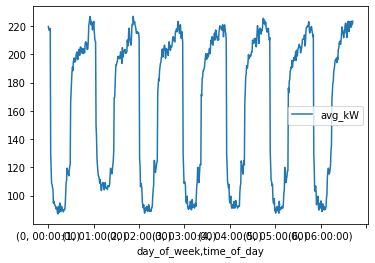

In [61]:
temp_ts[['avg_kW', 'day_of_week', 'time_of_day']].groupby(by=['day_of_week', 'time_of_day']).median().plot()

In [313]:
temp_week = temp_ts[['avg_kW', 'day_of_week', 'time_of_day']].groupby(by=['day_of_week', 'time_of_day']).median()

In [197]:
def high_load_start_stop(weekly_interval_df):
    """
    Given a DataFrame with known operating and not operating times,
    return the start and stop time for each day.
    """
    shift_forward_fill = weekly_interval_df['high_load_period'].iloc[-1]
    shift_backward_fill = weekly_interval_df['high_load_period'].iloc[0]
    weekly_interval_df['high_start'] = (weekly_interval_df['high_load_period']
                                        < weekly_interval_df['high_load_period'].shift(-1,
                                                                                       axis=0,
                                                                                       fill_value=shift_backward_fill))
    weekly_interval_df['high_stop'] = (weekly_interval_df['high_load_period']
                                       > weekly_interval_df['high_load_period'].shift(-1,
                                                                                      axis=0,
                                                                                      fill_value=shift_backward_fill))
    weekly_interval_df['high_start'] = weekly_interval_df['high_start'].astype('int')
    weekly_interval_df['high_stop'] = weekly_interval_df['high_stop'].astype('int')
    return weekly_interval_df

In [314]:
temp_week['near_base_load'] = 0
temp_week['near_peak_load'] = 0
temp_week['base_delta'] = 0
temp_week['peak_delta'] = 0
temp_week['high_load_period'] = 0
temp_week['high_start'] = 0
temp_week['high_stop'] = 0
for day in temp_week.index.get_level_values(0).unique():
    temp_week.loc[(day, ), 'near_base_load'] = np.percentile(temp_week.loc[(day, ), 'avg_kW'], 2.5)
    temp_week.loc[(day, ), 'near_peak_load'] = np.percentile(temp_week.loc[(day, ), 'avg_kW'], 97.5)
    temp_week.loc[(day, ), 'base_delta'] = temp_week.loc[:, 'avg_kW'] - temp_week.loc[:, 'near_base_load']
    temp_week.loc[(day, ), 'peak_delta'] = temp_week.loc[:, 'near_peak_load'] - temp_week.loc[:, 'avg_kW']
    temp_week.loc[(day, ), 'high_load_period'] = temp_week.loc[:, 'base_delta'] > temp_week.loc[:, 'peak_delta']

temp_week['high_load_period'] = temp_week['high_load_period'].astype('int')
temp_week = high_load_start_stop(temp_week)

In [315]:
temp_week.loc[(day, ), 'near_base_load'][0]
temp_week['near_peak_load'].max()

223.905

In [312]:
temp_week.index.get_level_values(0).unique()

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64', name='day_of_week')

In [233]:
temp_week.near_base_load.unique()

array([ 88.3125, 104.4   ,  88.8   ,  90.57  ,  91.2   ,  89.025 ,
        90.    ])

In [234]:
temp_week.near_peak_load.unique()

array([223.905 , 223.155 , 220.35  , 219.6   , 223.7625, 220.0625,
       223.2   ])

In [318]:
temp_week.tail(96)

avg_kW  near_base_load  near_peak_load  base_delta  \
day_of_week time_of_day                                                       
6           00:00:00     214.95            90.0           223.2      124.95   
            00:15:00     216.40            90.0           223.2      126.40   
            00:30:00     217.20            90.0           223.2      127.20   
            00:45:00     219.40            90.0           223.2      129.40   
            01:00:00     219.60            90.0           223.2      129.60   
            01:15:00     216.80            90.0           223.2      126.80   
            01:30:00     215.16            90.0           223.2      125.16   
            01:45:00     212.40            90.0           223.2      122.40   
            02:00:00     213.90            90.0           223.2      123.90   
            02:15:00     129.60            90.0           223.2       39.60   
            02:30:00     120.00            90.0           223.2       30.00   
            02:45:00     103.20            90.0           223.2       13.20   
            03:00:00     103.20            90.0           223.2       13.20   
            03:15:00     106.80            90.0           223.2       16.80   
            03:30:00     103.20            90.0           223.2       13.20   
            03:45:00      93.60            90.0           223.2        3.60   
            04:00:00      97.20            90.0           223.2        7.20   
            04:15:00      96.40            90.0           223.2        6.40   
            04:30:00      99.60            90.0           223.2        9.60   
            04:45:00      93.60            90.0           223.2        3.60   
            05:00:00      89.80            90.0           223.2       -0.20   
            05:15:00      90.12            90.0           223.2        0.12   
            05:30:00      93.60            90.0           223.2        3.60   
            05:45:00      94.80            90.0           223.2        4.80   
            06:00:00      91.44            90.0           223.2        1.44   
            06:15:00      96.30            90.0           223.2        6.30   
            06:30:00      91.20            90.0           223.2        1.20   
            06:45:00      88.80            90.0           223.2       -1.20   
            07:00:00      90.00            90.0           223.2        0.00   
            07:15:00      94.20            90.0           223.2        4.20   
            07:30:00      90.84            90.0           223.2        0.84   
            07:45:00      90.00            90.0           223.2        0.00   
            08:00:00      92.40            90.0           223.2        2.40   
            08:15:00      90.00            90.0           223.2        0.00   
            08:30:00      90.36            90.0           223.2        0.36   
            08:45:00      90.54            90.0           223.2        0.54   
            09:00:00      92.10            90.0           223.2        2.10   
            09:15:00      98.40            90.0           223.2        8.40   
            09:30:00     100.50            90.0           223.2       10.50   
            09:45:00     113.10            90.0           223.2       23.10   
            10:00:00     117.00            90.0           223.2       27.00   
            10:15:00     119.40            90.0           223.2       29.40   
            10:30:00     117.90            90.0           223.2       27.90   
            10:45:00     115.20            90.0           223.2       25.20   
            11:00:00     116.40            90.0           223.2       26.40   
            11:15:00     118.20            90.0           223.2       28.20   
            11:30:00     122.40            90.0           223.2       32.40   
            11:45:00     132.00            90.0           223.2       42.00   
            12:00:00     135.60            90.0           223.2       45.60

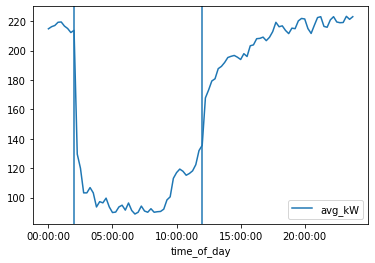

In [229]:
temp_week.loc[(6, ), ['avg_kW']].plot()
temp_start = temp_week.xs(6).loc[temp_week.xs(6).loc[:,'high_start'] == 1].index[0]
temp_start = list(temp_week.xs(6).index).index(temp_start)
temp_stop = temp_week.xs(6).loc[temp_week.xs(6).loc[:,'high_stop'] == 1].index[0]
temp_stop = list(temp_week.xs(6).index).index(temp_stop)
# print(temp_start, temp_stop)
plt.gca().axvline(temp_start)
plt.gca().axvline(temp_stop)
# ax = plt.gca() # get axis handle

# line = ax.lines[0] # get the first line, there might be more

# print(line.get_xdata())

In [ ]:
# calculating Load Shape Parameters based on literature from Lawrence Berkeley National Lab


In [84]:
np.percentile(temp_week.loc[temp_week.index.get_level_values(0) == 6, 'avg_kW'], 2.5)

90.0

# Identifying Data Gaps
I wanted to start with this problem because 1) the nature and frequency of the gaps may impact the algorithms used to solve other problems, and 2) I had the clearest initial idea for solving it.

In [14]:
all_gap_dates = functions.multi_site_gap_date_df(site_list)
all_gap_dates.to_csv('deliverables\gap_dates.csv', index=False)